### Dimensionality reduction 

#### Step1: Read data

##### Simulation data

In [26]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pylab as plt

# Cantera data
with open('YTP_H2_Li.npy', 'rb') as fid1:    
    X=np.load(fid1)
    p=np.load(fid1)
    RR = np.load(fid1)
    Yo = X[:,:nsc]; To = X[:,nv-1]
    
# PC data
# second moment
with open('PV2_H2_Li.npy', 'rb') as fid2:    
    S2=np.load(fid2)
    U2=np.load(fid2)
    
# fourth moment
with open('PV4_H2_Li.npy', 'rb') as fid4:    
    S4=np.load(fid4)
    U4=np.load(fid4)    
    
    
# fourth cumulant moment
with open('PV42_H2_Li.npy', 'rb') as fid42:
    S42=np.load(fid42)
    U42=np.load(fid42)    

In [27]:
# Get meta data
[nx, nv] = X.shape      # number of samples and variables
nsc = nv - 1            # number of species
nt = nx

### Step 2: Construct reduced data

### Necessary functions

In [28]:
def meanMinMax(v):
    v_mean = np.mean(v, axis=0)
    v_max = np.max(np.abs(v), axis=0)
    v_min = np.min(np.abs(v), axis=0)

    return v_mean, v_min, v_max

def scaleData(nf, v):
    vs = np.zeros((nx,nv))
    # compute mean
    v_mean = np.mean(v, axis=0)
    v_max = np.max(np.abs(v), axis=0)

    # add for loop to scale the data: NORMALIZATION
    for i in range(nf):
        vs[:, i] = (v[:, i] - v_mean[i])/v_max[i]

    return vs
                  
def unscaleData(vsq, vmean, vmax):
    vq = np.zeros((nx,nv))
                  
    # add for loop to scale the data: NORMALIZATION
    for i in range(nv):
        vq[:, i] = (vsq[:, i] * vmax[i] + vmean[i])

    return vq    


# function to get truncated matrix
def truncateVecs(nv,q,U):
    U_q = np.zeros((nv,q), dtype=float, order='F')
    U_q = np.copy(U[:,0:q,])
    return U_q


# function to construct PC data
def constructPCData(nx,q,Xs,Uq):
    Z_q = np.zeros((nx,q), dtype=float, order='F')
    Z_q = np.matmul(Xs,Uq)
    return Z_q


# function to reconstruct original data
def reconstructData(nv,nx,Zq,Uq):
    X_sq = np.zeros((nx,nv), dtype=float, order='F')
    X_sq = np.matmul(Zq,Uq.transpose())
    return X_sq

#### Cantera functions

In [29]:
gas = ct.Solution('/Users/aditya/work/projects/isml/jupyter/mech/H2_Li/H2_Li.cti')
nRR = gas.n_reactions        # number of reactions


# compute reaction rate
def computeRR(Yq,Tq,P):
    RRq = np.zeros((nt,nRR))   # reaction rates matrix

    for it in range(nt):
        gas.TP = Tq[it],p[it]
        gas.Y = Yq[it,:nsc]
        for ir in range(nRR):
            RRq[it,ir] = gas.net_rates_of_progress[ir]
            
    return RRq


#### Scale data

In [30]:
Xs = scaleData(nv,X)
Xmean, Xmin, Xmax = meanMinMax(X)

#### q Loop

In [87]:
q = [4] # number of retained principal vectors

for iq in q:
    # allocate variables
    U2q = np.zeros((nv,iq), dtype=float, order='F')
    Z2q = np.zeros((nx,iq), dtype=float, order='F')
    Xs2q = np.zeros((nx,nv), dtype=float, order='F')
    
    U4q = np.zeros((nv,iq), dtype=float, order='F')
    Z4q = np.zeros((nx,iq), dtype=float, order='F')
    Xs4q = np.zeros((nx,nv), dtype=float, order='F')
    
    U42q = np.zeros((nv,iq), dtype=float, order='F')
    Z42q = np.zeros((nx,iq), dtype=float, order='F')
    X42q = np.zeros((nx,nv), dtype=float, order='F')
    
    # truncate vectors
    U2q = truncateVecs(nv,iq,U2)
    U4q = truncateVecs(nv,iq,U4)
    U42q = truncateVecs(nv,iq,U42)
    
    # construct PC data
    Z2q = constructPCData(nx,iq,Xs,U2q)
    Z4q = constructPCData(nx,iq,Xs,U4q)
    Z42q = constructPCData(nx,iq,Xs,U42q)
    
    # reconstruct data
    Xs2q = reconstructData(nv,nx,Z2q,U2q)
    Xs4q = reconstructData(nv,nx,Z4q,U4q)
    Xs42q = reconstructData(nv,nx,Z42q,U42q)
    
    # unscale data
    X2q = unscaleData(Xs2q, Xmean, Xmax)
    X4q = unscaleData(Xs4q, Xmean, Xmax)
    X42q = unscaleData(Xs42q, Xmean, Xmax)
    
    Y2q = X2q[:,:nsc]; T2q = X2q[:,nv-1]
    Y4q = X4q[:,:nsc]; T4q = X4q[:,nv-1]
    Y42q = X42q[:,:nsc]; T42q = X42q[:,nv-1]
    
    # compute reaction rate
    RR2q = computeRR(Y2q,T2q,p)
    RR4q = computeRR(Y4q,T4q,p)
    RR42q = computeRR(Y42q,T42q,p)
    

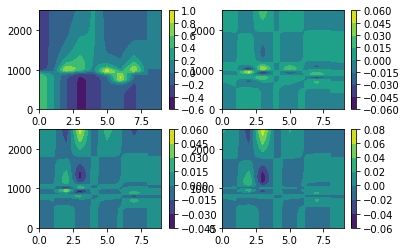

In [88]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)

f1=ax1.contourf(Xs)
fig.colorbar(f1,ax=ax1)

f2=ax2.contourf(Xs2q-Xs)
fig.colorbar(f2,ax=ax2)

f3=ax3.contourf(Xs4q-Xs)
fig.colorbar(f3,ax=ax3)

f4=ax4.contourf(Xs42q-Xs)
fig.colorbar(f4,ax=ax4)

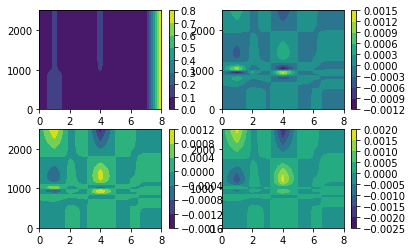

In [89]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)

f1=ax1.contourf(Yo)
fig.colorbar(f1,ax=ax1)

f2=ax2.contourf(Y2q-Yo)
fig.colorbar(f2,ax=ax2)

f3=ax3.contourf(Y4q-Yo)
fig.colorbar(f3,ax=ax3)

f4=ax4.contourf(Y42q-Yo)
fig.colorbar(f4,ax=ax4)

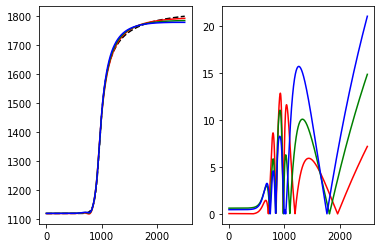

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(To,'--k')
ax1.plot(T2q,'-r')
ax1.plot(T4q,'-g')
ax1.plot(T42q,'-b')

ax2.plot(np.abs(T2q-To),'-r')
ax2.plot(np.abs(T4q-To),'-g')
ax2.plot(np.abs(T42q-To),'-b')


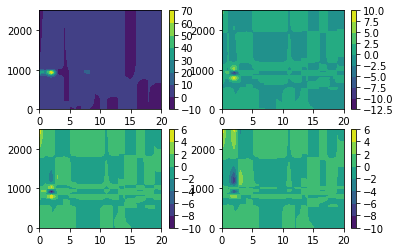

In [91]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)

f1=ax1.contourf(RR)
fig.colorbar(f1,ax=ax1)

f2=ax2.contourf(RR2q-RR)
fig.colorbar(f2,ax=ax2)

f3=ax3.contourf(RR4q-RR)
fig.colorbar(f3,ax=ax3)

f4=ax4.contourf(RR42q-RR)
fig.colorbar(f4,ax=ax4)

In [92]:
np.argmax(np.abs(RR2q-RR)[1])
np.argmax(np.abs(RR2q-RR)[1])


1